# GLMのベイズモデル化と事後分布の推定
焦点は線形予測しを持つ統計モデルのベイズ化、複数のパラメーターの事後分布からのMCMCサンプリングです。

## 9.1種子数のポアソン回帰（個体差なし）
架空データに基づいて、個体ごとの平均種子数が体サイズx_iにどう依存しているのかを調べるのが目的。個体差は無いので、このデータのばらつきはポアソン分布で表現できます。

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
data_T = pd.read_csv('d.csv')

In [6]:
data = data_T.T[1:]

In [9]:
data = data.rename(columns={0:'x',1:'y'})

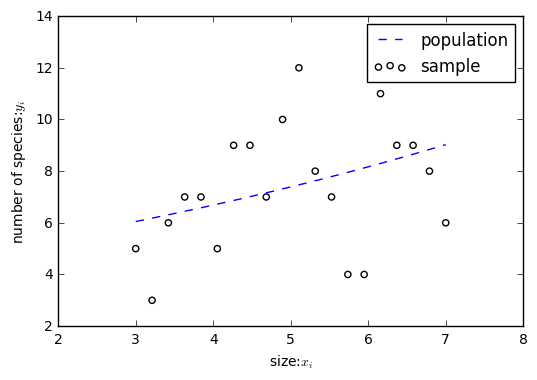

In [10]:
plt.scatter(data.x,data.y,facecolor='none',label='sample')
plt.plot(np.linspace(3,7,10),np.exp(1.5+0.1*np.linspace(3,7,10)),'--',label='population')
plt.legend(loc='upper right')
plt.xlabel('size:$x_{i}$')
plt.ylabel('number of species:$y_{i}$')

In [11]:
data.x_c = sm.add_constant(data.x)
result = sm.GLM(data.y,data.x_c,family=sm.families.Poisson()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -45.018
Date:                Mon, 06 Feb 2017   Deviance:                       14.171
Time:                        23:32:45   Pearson chi2:                     13.6
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.5661      0.360      4.351      0.000         0.861     2.272
x              0.0833      0.068      1.219      0.223        -0.051     0.217
==============================================================================
"""

## 9.2GLMのベイズモデル化
ベイズモデル化したGLMでも、モデルの中核部分はこれまでに登場したポアソン回帰のGLMです。

ベイズモデルの事後分布は（尤度）×（事前分布）に比例しますから、この例では以下の関係が成り立ちます。


$$p(\beta_{1},\beta_{2}|{\bf Y}) \propto p({\bf Y}|\beta_{1},\beta_{2})p(\beta_{1})p(\beta_{2})$$

左辺は事後分布であり、データYが得られた時の$\beta_{1},\beta_{2}$の同時確率分布です。右辺は事前分布であり、これらを適切に指定すればベイズモデル化したGLMとなります。

## 9.3無情報事前分布
事前分布はデータYが得られていない時のパラメータの確率分布ですが、そんなものはわかるはずもありません。そこで、線形予測しのパラメータ$\beta_{*}$の値は$[-\infty,\infty]$の範囲で好きな値をとって良いと言ったことを表現する事前分布$p(\beta_{*})$を設定します。このよううな事前分布は無情報事前分布と呼ばれます。

ここでは無情報っぽい事前分布として以下の2種類の確率分布がよく使われる。ひとつは、例えば$-10^{9}<\beta_{*}<10^{9}$の範囲をとる一様分布を設定する方法です。もうひとつは平均ゼロで標準偏差がとても大きい平べったい正規分布です。取りうる$\beta_{*}$の範囲が十分に広ければ推定される結果にほとんど影響はありません。

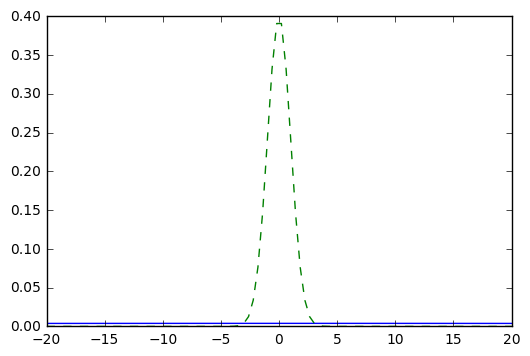

In [12]:
y = np.linspace(-20,20,100)
plt.plot(y,stats.norm.pdf(y,0,100))
plt.plot(y,stats.norm.pdf(y,0,1),'--')
plt.show()

### 9.4ベイズ統計モデルの事後分布の推定

In [2]:
import pymc

In [16]:
basic_model = pymc.Model()
#事前分布
beta1 = pymc.Normal('beta1',0.,tau=1.0e-3) #tauは分散の逆数、標準偏差は1/sqrt(tau)となる。
beta2 = pymc.Normal('beta2',0.,tau=1.0e-3)

#決定論的な関係
@pymc.deterministic(plot=False)
def mu(beta1=beta1,beta2=beta2,x=data.x):
    return np.exp(beta1 + beta2*(x - x.mean()))

Y_obs = pymc.Poisson('Y_obs',mu=mu,value=data.y,observed=True)

model = pymc.Model([beta1,beta2,Y_obs])
start = pymc.MCMC(model)
start.sample(iter=105000, burn=5000, thin=10)

 [-----------------100%-----------------] 105000 of 105000 complete in 145.8 sec

Plotting beta1
Plotting beta2


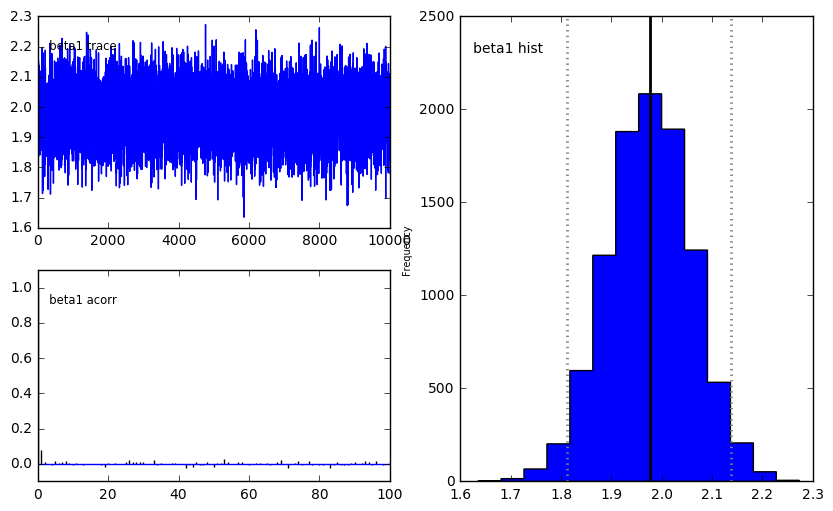

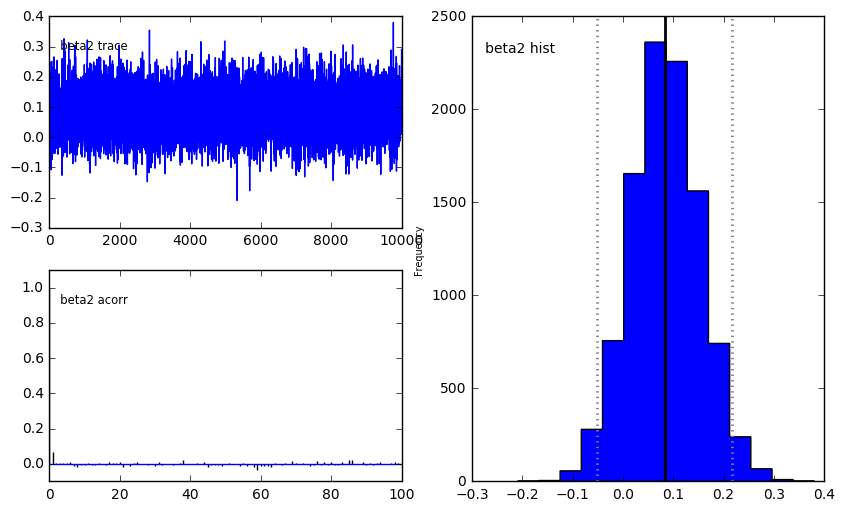

In [17]:
pymc.Matplot.plot(start)

$beta_{1},beta{2}$のそれぞれの周辺事後分布が表示されている。

In [24]:
import pydot
import scipy.misc
from PIL import Image

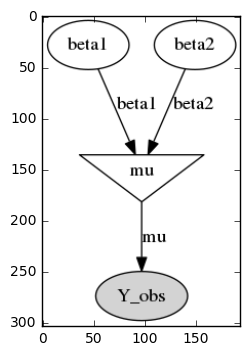

In [27]:

pymc.graph.graph(model,format='png',path='',name='model',prog='dot')
img = np.array(Image.open('model.png'))
#figure(figsize=(8,8))
plt.imshow(img)

### 9.4.3どれだけ長くMCMCサンプリングすれば良いのか？
R指数により、系列間の乖離具合がわかる。
サンプル間でばらつきが大きい場合は定常分布、事後分布は推定できないと判断する。

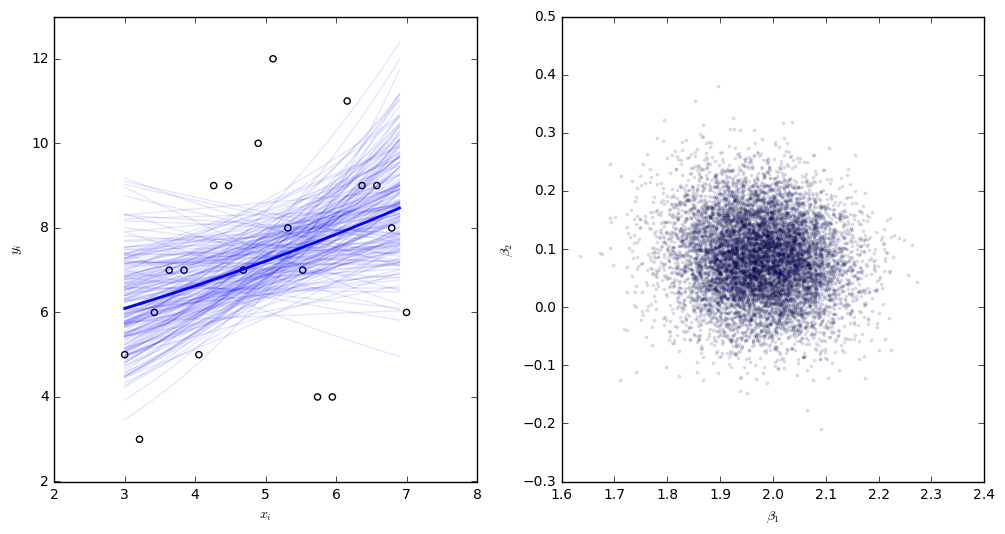

In [61]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
x = np.arange(3,7,0.1)
ax[0].scatter(data.x,data.y,facecolor='none')
for i in np.arange(0,start.trace('beta2')[:].shape[0],50):
    ax[0].plot(x,np.exp(start.trace('beta1')[i]+(x-data.x.mean())*start.trace('beta2')[i]),lw=1,alpha=0.1,c='b')
ax[0].plot(x,np.exp(start.trace('beta1')[:].mean()+(x-data.x.mean())*start.trace('beta2')[:].mean()),lw=2,alpha=1,c='b')
ax[0].set_ylim([2,13])
ax[0].set(xlabel='$x_{i}$',ylabel='$y_{i}$')

ax[1].scatter(start.trace('beta1')[:],start.trace('beta2')[:],s=3,alpha=0.1)
ax[1].set(xlabel='$\\beta_{1}$',ylabel='$\\beta_{2}$')

### 9.5.1事後分布の統計量

In [62]:
beta1.stats()

{'95% HPD interval': array([ 1.8124625 ,  2.13804077]),
 'mc error': 0.00096370780172342512,
 'mean': 1.9759003412202429,
 'n': 10000,
 'quantiles': {2.5: 1.811956606508105,
  25: 1.9197116709389577,
  50: 1.9765932765068723,
  75: 2.0332497810435419,
  97.5: 2.1379842248240024},
 'standard deviation': 0.083398225457005801}

In [63]:
beta2.stats()

{'95% HPD interval': array([-0.05077435,  0.21699307]),
 'mc error': 0.00073915595960145984,
 'mean': 0.084500310214896929,
 'n': 10000,
 'quantiles': {2.5: -0.049596760145306958,
  25: 0.038505160702253828,
  50: 0.08364695136633174,
  75: 0.1299941061628708,
  97.5: 0.21943670283556022},
 'standard deviation': 0.068478767430230139}